In [ ]:
#importing dependencies related to nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#importing dependencies related to image transformations
import torchvision
from torchvision import transforms
from PIL import Image

#importing dependencies related to data loading
from torchvision import datasets
from torch.utils.data import DataLoader

#importing Tensorboard for data visualization
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [ ]:
# loading data
data = {
    'train':
    datasets.ImageFolder(root='/content/drive/MyDrive/ML Assignment/dataset/train', transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root='/content/drive/MyDrive/ML Assignment/dataset/test', transform=image_transforms['test']),
}

# Dataloader iterators, used for making batches
dataloaders = {
    'train': DataLoader(data['train'], batch_size=100, shuffle=True),
    'test': DataLoader(data['test'], batch_size=100, shuffle=True)}

In [ ]:

#loading MobileNetv2
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
#freezing the initial layers of MobileNetv2
for param in model.parameters():
    param.requires_grad = False

In [ ]:
#adding our own classifier
model.classifier[1] = nn.Sequential(
                      nn.Linear(1280, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(32, 2), 
                      nn.LogSoftmax(dim=1))

In [ ]:
#checking trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

371234


In [ ]:

#training data
from tqdm.notebook import tqdm #for loading bars

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs,device):
    writer = SummaryWriter("saves/logs")
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in (train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in (val_loader):
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)          
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,valid_loss, num_correct / num_examples))
        
        #save model
        if(training_loss<0.005):
            torch.save(model,"saves/"+str(epoch)+".pth")
        
        #tensorBoard save log
        writer.add_scalar('Loss', loss.item(), epoch)
        writer.add_scalar('Train/Loss', training_loss, epoch)
        writer.add_scalar('Test/Loss', valid_loss, epoch)
        writer.add_scalar('Test/Accuracy',num_correct / num_examples, epoch)
        writer.flush()

In [ ]:
#testing data
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [ ]:
#put model to GPU (if available)
model=model.to(device)

In [ ]:
#choosing optimizer and loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
#train the model first 20 epochs
train(model, optimizer,loss,dataloaders['train'],dataloaders['test'],20,device)

Epoch: 0, Training Loss: 0.7045, Validation Loss: 0.6685, accuracy = 0.4405
Epoch: 1, Training Loss: 0.6467, Validation Loss: 0.6661, accuracy = 0.4286
Epoch: 2, Training Loss: 0.5750, Validation Loss: 0.5813, accuracy = 0.4524
Epoch: 3, Training Loss: 0.5262, Validation Loss: 0.4910, accuracy = 0.8452
Epoch: 4, Training Loss: 0.4211, Validation Loss: 0.4401, accuracy = 0.8333
Epoch: 5, Training Loss: 0.3517, Validation Loss: 0.3844, accuracy = 0.9167
Epoch: 6, Training Loss: 0.2998, Validation Loss: 0.3394, accuracy = 0.9405
Epoch: 7, Training Loss: 0.2606, Validation Loss: 0.2962, accuracy = 1.0000
Epoch: 8, Training Loss: 0.2496, Validation Loss: 0.2581, accuracy = 1.0000
Epoch: 9, Training Loss: 0.2058, Validation Loss: 0.2308, accuracy = 0.9643
Epoch: 10, Training Loss: 0.1442, Validation Loss: 0.1496, accuracy = 0.9881
Epoch: 11, Training Loss: 0.1043, Validation Loss: 0.0602, accuracy = 1.0000
Epoch: 12, Training Loss: 0.0607, Validation Loss: 0.0308, accuracy = 1.0000
Epoch: 13

In [ ]:
#test the model
test_model(model)

correct: 82  total: 84
accuracy = 0.976190


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
face_clsfr=cv2.CascadeClassifier('/content/drive/MyDrive/ML Assignment/haarcascade_frontalface_default.xml')

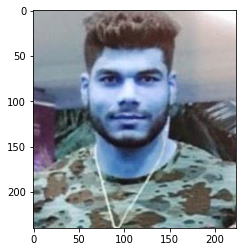

In [ ]:
img = cv2.imread('/content/drive/MyDrive/ML Assignment/demo.jpg')
plt.imshow(img)

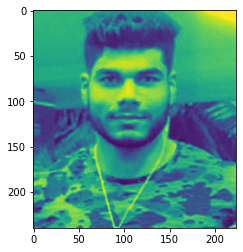

In [ ]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

In [ ]:
faces=face_clsfr.detectMultiScale(gray,1.3,3)
print(f'Number of faces found = {len(faces)}')

Number of faces found = 1


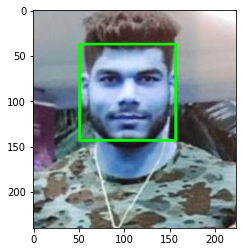

In [ ]:
for (x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), thickness=2)

plt.imshow(img)

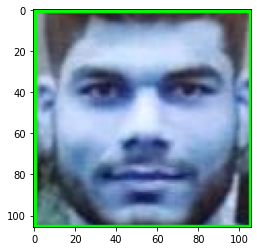

In [ ]:
face_img=img[y:y+w,x:x+w]
#resized=cv2.resize(face_img,(100,100))
#normalized=resized/255.0
#reshaped=np.reshape(normalized,(1,100,100,1))
plt.imshow(face_img)


In [ ]:
transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])])
transform = transforms.ToTensor()

In [ ]:
face_img = transform(face_img)

In [ ]:

face_img = torch.stack([face_img])
face_img = face_img.to(device)

In [ ]:
model.eval()
result=model(face_img)
print(result.data)

tensor([[-0.1387, -2.0441]], device='cuda:0')


In [ ]:
label = 1
_, predicted = torch.max(result.data, 1)
if predicted==label:
   print("mask")
else:
  print("no mask")

no mask
